In [1]:
from src import incremental_transformer as it
from src import shift_comparison_predictor as shift_pred
from src import simple_comparison_predictor as simple_pred
import pandas as pd
from src import normalization as norm
import numpy as np
import datetime
%matplotlib inline

In [3]:
# import plotly.plotly as py
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 7, 5

In [4]:
def rmse(prediction, target):
    return np.sqrt(((prediction - target) ** 2).mean())

In [5]:
def mape(prediction, target):
    return np.mean(np.abs((target - prediction) / target)) * 100

In [6]:
def smape(prediction, target):
    return np.mean(np.abs(target - prediction) / np.abs(target + prediction)) * 200

In [7]:
def mae(prediction, target):
    return np.mean(np.abs(target - prediction)) * 100

In [8]:
def mdae(prediction, target):
    return np.median(np.abs(target - prediction)) * 100

In [34]:
filename = "../data/01_zilina_suma.csv"
# data = pd.DataFrame.from_csv(filename, index_col=[0,1])
data = pd.read_csv(filename, sep=',')

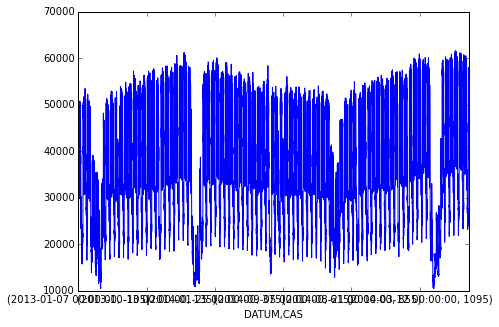

In [10]:
data.SUM_of_MNOZSTVO.plot()

In [13]:
24*60

1440

In [35]:
data.columns

Index([u'DATUM', u'CAS', u'SUM_of_MNOZSTVO'], dtype='object')

In [68]:
def get_date(row):
    day, month, year = [int(part) for part in row["DATUM"].split("/")]
    tmp = datetime.datetime(year, month, day, 0, 0)
    return tmp + datetime.timedelta(minutes = row['CAS'] + 105)

In [62]:
data.ix[11424]

DATUM              27/10/2013
CAS                      1335
SUM_of_MNOZSTVO       23001.7
Name: 11424, dtype: object

In [60]:
105/15

7

In [66]:
get_date(data.ix[11425])


datetime.datetime(2013, 10, 28, 5, 30)

In [69]:
dates = data.apply(get_date, axis=1)
dates.head()

0   2013-07-01 00:00:00
1   2013-07-01 00:15:00
2   2013-07-01 00:30:00
3   2013-07-01 00:45:00
4   2013-07-01 01:00:00
dtype: datetime64[ns]

In [78]:
data['TIME'] = dates
data = data.set_index(['TIME'])

In [79]:
data.head()

,DATUM,CAS,SUM_of_MNOZSTVO
TIME,,,
2013-07-01 00:00:00,01/07/2013,-105,21674.275309
2013-07-01 00:15:00,01/07/2013,-90,21819.158939
2013-07-01 00:30:00,01/07/2013,-75,21577.701649
2013-07-01 00:45:00,01/07/2013,-60,21538.008315
2013-07-01 01:00:00,01/07/2013,-45,21021.863567


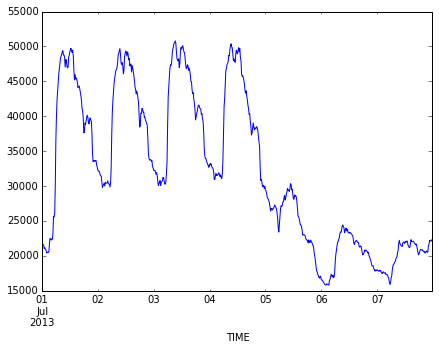

In [80]:
data.SUM_of_MNOZSTVO[:(96*7)].plot()

In [81]:
normalization = norm.ZNormalization()

In [82]:
# Natrenovanie koeficientov normalizacie na prvom tyzdni dat
normalization.train_coefficients(data.SUM_of_MNOZSTVO[0:(96*7)])

In [83]:
trans = it.IncrementalTransformer(96, 48, 2.0, normalization=normalization)
symbols = trans.transform(data.SUM_of_MNOZSTVO[0:(96*7)])

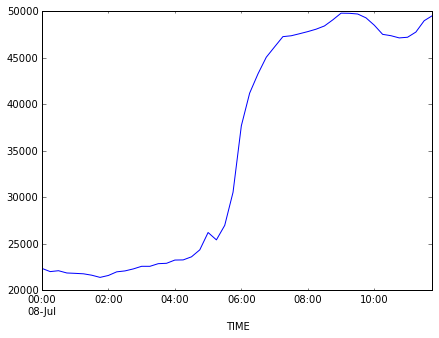

In [84]:
data.SUM_of_MNOZSTVO[(96*7):(96*7+48)].plot()

In [85]:
predictor = simple_pred.SimpleComparisonPredictor(trans)
prediction = predictor.predict()

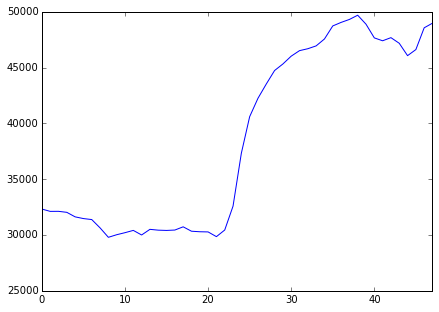

In [86]:
p = (prediction.series[48:] * normalization.scale) + normalization.shift
pd.Series(p).plot()

In [87]:
t = data.SUM_of_MNOZSTVO[(96*7):(96*7+48)]

In [88]:
rmse(p, t)

5657.6501701570023

In [89]:
smape(p, t)

15.105896701552288

In [148]:
# zatial su vsetky moje obrazky postavene na predikcii jedneho tyzdna s tyzdnovou inicializaciou. Treba obrazky spravit aj pre cele data
test_data = data.SUM_of_MNOZSTVO[:(96*7*2)]

In [176]:
week = 96*7
symbol_length = 96
step = 48

normalization = norm.ZNormalization()
normalization.train_coefficients(test_data[0:week])
trans = it.IncrementalTransformer(symbol_length, step, 1.5, normalization=normalization)
symbols = trans.transform(test_data[0:(week-step)])
predictor = simple_pred.SimpleComparisonPredictor(trans)

rmse_result = []
smape_result = []

t_target = pd.Series([])
t_prediction = pd.Series([])

i = week
length = len(test_data)
while(i <= length - step):
    symbols = trans.transform(test_data[(i-step):i])        
    prediction = predictor.predict()
    t = test_data[i:(i+step)]
    t_target = t_target.append(t)
    p = (prediction.series[step:] * normalization.scale) + normalization.shift
    t_prediction = t_prediction.append(pd.Series(p))
    rmse_result.append(rmse(p, t))
    smape_result.append(smape(p, t))
    if(i % week == 0): # vzyd po tyzdni sa updatuju koeficienty normalizacie aby sa odstranili sezonne vplyvy vacsie ako 1 tyzden
        normalization.train_coefficients(test_data[(i-week):i])
    i+=step


In [177]:
t_prediction = t_prediction.reset_index()
t_target = t_target.reset_index()

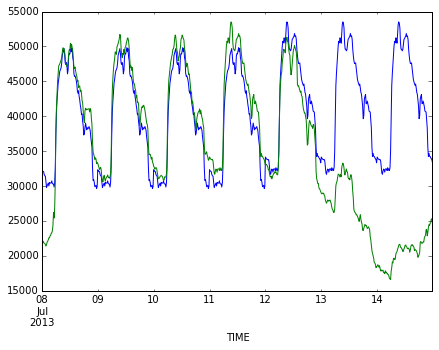

In [178]:
index = test_data[week:].index
t_prediction[0].index = index
t_target['SUM_of_MNOZSTVO'].index = index

t_prediction[0].plot()
t_target['SUM_of_MNOZSTVO'].plot()

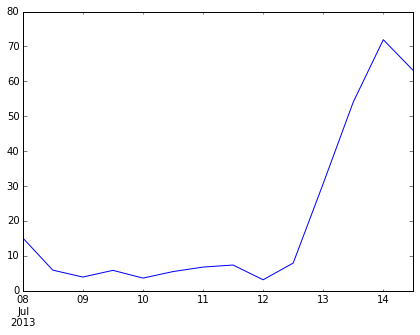

In [179]:
# pd.Series(smape_result).plot()
error = pd.Series(smape_result)
dates = [t for t in index if t.minute == 0 and (t.hour == 0 or t.hour == 12)]
error.index = dates
error.plot()

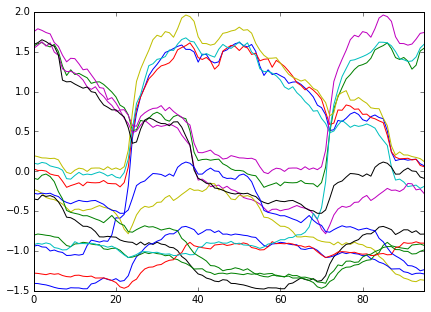

In [180]:
[ pd.Series(symbol.series).plot() for symbol in trans.distance_matrix.symbols()]

#Shift comparison predictor
teraz to treba vlozit do nejakeho cyklu, ktory bude postupne davat data po poldnoch a bude predikovat presnost na dalsom poldni. Presnost sa bude vyhodnocovat inkrementalne tak aby som sa mohol pozriet na to, ci sa nejak zlepsuje. Ak to bude prilis rozlietane, tak mozem robit nejake vyhladzovanie (priemer cez running window).
Treba si ale pamatat, ze po kazdom tyzdni musim preucit normalziacne koeficienty aby som odstranil problemy so sezonnostou na vyssej urovni ako je jeden tyzden
najvacsi vyznam ma pouzivat metriky rmse, smape a mae. Z tychto len smape je percentualna, takze nezavysla na pouzitych datach

# A teraz na vsetkych datach

In [118]:
test_data = data.SUM_of_MNOZSTVO#[:(96*7*2)]

In [139]:
week = 96*7
symbol_length = 96
step = 48

normalization = norm.ZNormalization()
normalization.train_coefficients(test_data[0:week])
trans = it.IncrementalTransformer(symbol_length, step, 0.5, normalization=normalization)
symbols = trans.transform(test_data[0:(week-step)])
predictor = simple_pred.SimpleComparisonPredictor(trans)

rmse_result = []
smape_result = []

t_target = pd.Series([])
t_prediction = pd.Series([])

i = week
length = len(test_data)
while(i <= length - step):
    symbols = trans.transform(test_data[(i-step):i])        
    prediction = predictor.predict()
    t = test_data[i:(i+step)]
    t_target = t_target.append(t)
    p = (prediction.series[step:] * normalization.scale) + normalization.shift
    t_prediction = t_prediction.append(pd.Series(p))
    rmse_result.append(rmse(p, t))
    smape_result.append(smape(p, t))
#     if(i % week == 0): # vzyd po tyzdni sa updatuju koeficienty normalizacie aby sa odstranili sezonne vplyvy vacsie ako 1 tyzden
#         print(normalization.scale, normalization.shift)        
#         normalization.train_coefficients(test_data[(i-(2*week)):i])
    i+=step


In [140]:
t_prediction = t_prediction.reset_index()
t_target = t_target.reset_index()

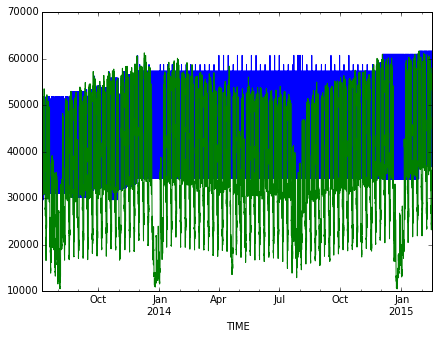

In [141]:
index = test_data[week:].index
index_part = index[:len(t_prediction[0])]
t_prediction[0].index = index_part
t_target['SUM_of_MNOZSTVO'].index = index_part

t_prediction[0].plot()
t_target['SUM_of_MNOZSTVO'].plot()

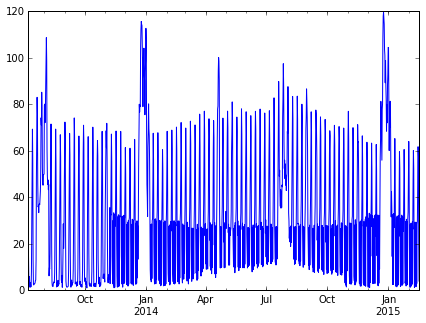

In [142]:
# pd.Series(smape_result).plot()
error = pd.Series(smape_result)
dates = [t for t in index if t.minute == 0 and (t.hour == 0 or t.hour == 12)]
error.index = dates[:len(error)]
error.plot()

In [143]:
np.mean(smape_result)

32.447185873749405

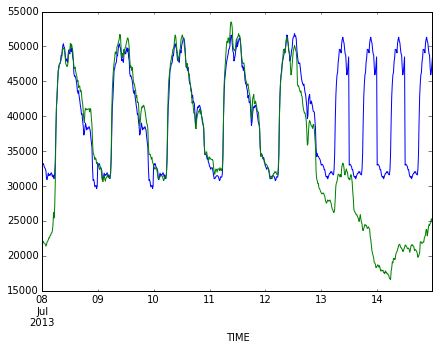

In [116]:
# index = data.SUM_of_MNOZSTVO[820:].index
# t_prediction[0].index = index
# t_target['SUM_of_MNOZSTVO'].index = index

t_prediction[0].plot()
t_target['SUM_of_MNOZSTVO'].plot()

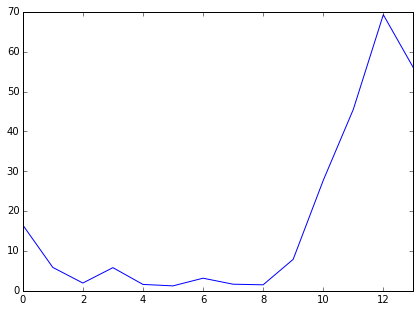

In [117]:
pd.Series(smape_result).plot()

In [15]:
np.mean(smape_result)

6.525767338314

#Porovnanie so standardnou metodou

In [17]:
from pandas.stats.moments import ewma
import numpy as np

pred_period = symbol_length

def predict(x,span,periods = pred_period):     
    x_predict = np.zeros((span+periods,))
    x_predict[:span] = x[-span:]
    pred =  ewma(x_predict,span)[span:]

    return pred

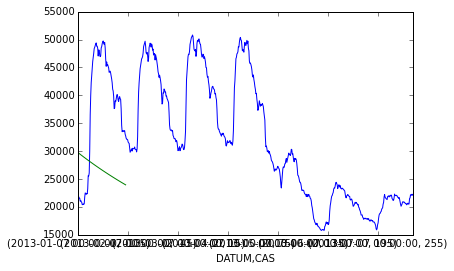

In [18]:

source = data.SUM_of_MNOZSTVO[:week]
prediction = predict(source, week)
source.plot()
pd.Series(prediction).plot()

In [183]:
len(data)

57220